<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.06 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 15:38:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 9.7 MB/s 
     |████████████████████████████████| 138 kB 48.2 MB/s 
     |████████████████████████████████| 133 kB 47.2 MB/s 
     |████████████████████████████████| 170 kB 50.8 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 62 kB 789 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 6wgndl46
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/6wgndl46


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 74wlkpbt with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 58ms/step - loss: 1.5742 - mean_squared_error: 1.5742 - mean_absolute_error: 0.6678 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0907
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1057 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0922
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.0602 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.2172
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.1990 - mean_squared_error: 0.1990 - mean_absolute_error: 0.2118 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1091
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0129 - mean_squared_

epoch,10
loss,0.08007
mean_squared_error,0.08007
mean_absolute_error,0.14553
val_loss,0.28837
val_mean_squared_error,0.28837
val_mean_absolute_error,0.5214
_runtime,8
_timestamp,1627057513
_step,10
best_val_loss,0.0116


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▂▂▁▁▁▂▁▁▂
mean_squared_error,█▁▂▂▁▁▁▂▁▁▂
mean_absolute_error,█▃▃▃▂▃▁▃▁▂▃
val_loss,▁▁▁▁▅▁▄▁█▁▃
val_mean_squared_error,▁▁▁▁▅▁▄▁█▁▃
val_mean_absolute_error,▁▁▂▁▆▁▆▁█▁▅
_runtime,▁▁▁▅▅▅▅▅███
_timestamp,▁▁▁▅▅▅▅▅███
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: dxikpy7b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 61ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - mean_absolute_error: 0.2414 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1612
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0655 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1352
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0443 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1129
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0242 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1167
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squared_error

epoch,49
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02162
val_loss,0.00457
val_mean_squared_error,0.00457
val_mean_absolute_error,0.05068
_runtime,18
_timestamp,1627057539
_step,49
best_val_loss,0.00435


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▃▄▄▄▂▂▂▂▁▂▂▃▁▃▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,█▅▅▅▄▃▄▄▄▂▂▂▂▁▂▂▃▁▃▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,█▆▅▅▄▄▄▄▅▃▂▂▂▂▂▂▅▂▅▂▁▂▁▂▁▄▂▃▁▁▁▁▂▁▂▃▁▁▃▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e2rn8ip9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 112ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1401 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1619
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1634
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0327 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1594
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0299 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1546
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0016 

epoch,49
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01324
val_loss,0.01168
val_mean_squared_error,0.01168
val_mean_absolute_error,0.07652
_runtime,15
_timestamp,1627057570
_step,49
best_val_loss,0.01168


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇██▇▇▆▅▅▅▅▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇██▇▇▆▅▅▅▅▄▄▄▃▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,███▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gssg58iu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 113ms/step - loss: 2.9019 - mean_squared_error: 2.9019 - mean_absolute_error: 1.1407 - val_loss: 0.0496 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1591
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1080 - mean_squared_error: 0.1080 - mean_absolute_error: 0.2202 - val_loss: 0.4328 - val_mean_squared_error: 0.4328 - val_mean_absolute_error: 0.6147
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - mean_absolute_error: 0.1699 - val_loss: 0.1186 - val_mean_squared_error: 0.1186 - val_mean_absolute_error: 0.3163
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1319 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1837
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0092 - mean_squared_error: 0.0092 

epoch,41
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01407
val_loss,0.00571
val_mean_squared_error,0.00571
val_mean_absolute_error,0.06104
_runtime,14
_timestamp,1627057593
_step,41
best_val_loss,0.00362


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂█▄▃▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: k45zufub with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.3131 - mean_squared_error: 0.3131 - mean_absolute_error: 0.3612 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1211
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0299 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1281
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0223 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1209
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 9.3958e-04 - mean_squared_error: 9.3958e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1198
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 8.0739e-04 - mean_s

epoch,49
loss,0.0003
mean_squared_error,0.0003
mean_absolute_error,0.01036
val_loss,0.00739
val_mean_squared_error,0.00739
val_mean_absolute_error,0.06033
_runtime,17
_timestamp,1627057621
_step,49
best_val_loss,0.00698


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: agq98jzw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 6445.2173 - mean_squared_error: 6445.2173 - mean_absolute_error: 42.5362 - val_loss: 1.4011 - val_mean_squared_error: 1.4011 - val_mean_absolute_error: 0.6901
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.5240 - mean_squared_error: 0.5240 - mean_absolute_error: 0.4691 - val_loss: 2.3196 - val_mean_squared_error: 2.3196 - val_mean_absolute_error: 1.2363
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 134.7558 - mean_squared_error: 134.7558 - mean_absolute_error: 9.1962 - val_loss: 0.2081 - val_mean_squared_error: 0.2081 - val_mean_absolute_error: 0.3261
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.9995 - mean_squared_error: 0.9995 - mean_absolute_error: 0.4021 - val_loss: 20.6222 - val_mean_squared_error: 20.6222 - val_mean_absolute_error: 4.3561
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 479.8590 

epoch,25
loss,9.86333
mean_squared_error,9.86333
mean_absolute_error,1.71743
val_loss,6.28572
val_mean_squared_error,6.28572
val_mean_absolute_error,1.68082
_runtime,12
_timestamp,1627057641
_step,25
best_val_loss,0.03772


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
mean_absolute_error,▆▁▂▁▃▁▁▁▁▂▃▁▁▃▁▁▃▁▁▁▁█▁▁▃▁
val_loss,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁█▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇▇████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 9f208j1i with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 37ms/step - loss: 98.2046 - mean_squared_error: 98.2046 - mean_absolute_error: 6.6109 - val_loss: 0.6764 - val_mean_squared_error: 0.6764 - val_mean_absolute_error: 0.8058
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 2.7394 - mean_squared_error: 2.7394 - mean_absolute_error: 1.2043 - val_loss: 5.4715 - val_mean_squared_error: 5.4715 - val_mean_absolute_error: 2.3338
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 1.9288 - mean_squared_error: 1.9288 - mean_absolute_error: 1.0753 - val_loss: 0.0820 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.2621
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.3100 - mean_squared_error: 0.3100 - mean_absolute_error: 0.4332 - val_loss: 0.1101 - val_mean_squared_error: 0.1101 - val_mean_absolute_error: 0.3108
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.2416 - mean_square

epoch,20
loss,0.10863
mean_squared_error,0.10863
mean_absolute_error,0.26618
val_loss,0.13018
val_mean_squared_error,0.13018
val_mean_absolute_error,0.33941
_runtime,16
_timestamp,1627057665
_step,20
best_val_loss,0.05649


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▂█▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▂█▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▃█▁▁▁▂▂▂▂▃▁▃▁▂▃▂▂▁▂▂▂
_runtime,▁▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇█
_timestamp,▁▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: g57qgc3i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 193ms/step - loss: 0.7129 - mean_squared_error: 0.7129 - mean_absolute_error: 0.5912 - val_loss: 0.1748 - val_mean_squared_error: 0.1748 - val_mean_absolute_error: 0.3844
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - mean_absolute_error: 0.2166 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1363
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - mean_absolute_error: 0.1793 - val_loss: 0.1798 - val_mean_squared_error: 0.1798 - val_mean_absolute_error: 0.3887
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1000 - val_loss: 0.0835 - val_mean_squared_error: 0.0835 - val_mean_absolute_error: 0.2561
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0121 - mean_squared_error: 0.0121 

epoch,27
loss,0.00027
mean_squared_error,0.00027
mean_absolute_error,0.00937
val_loss,0.00644
val_mean_squared_error,0.00644
val_mean_absolute_error,0.06112
_runtime,12
_timestamp,1627057695
_step,27
best_val_loss,0.00452


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃█▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 9gqk6r4s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 64ms/step - loss: 0.1048 - mean_squared_error: 0.1048 - mean_absolute_error: 0.1984 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1085
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0287 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1032
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0200 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1069
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0227 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1049
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 8.9298e-04 - mean_squared_e

epoch,49
loss,0.0003
mean_squared_error,0.0003
mean_absolute_error,0.00988
val_loss,0.00463
val_mean_squared_error,0.00463
val_mean_absolute_error,0.04988
_runtime,24
_timestamp,1627057732
_step,49
best_val_loss,0.00463


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂▂▂█▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▆▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▂▂▂▂█▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▆▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▃▃▂▂█▂▂▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▇▂▃▃▁▃▁▂▃▁▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rnv304os with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 37ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - mean_absolute_error: 0.1735 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1255
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0370 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1011
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0273 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1034
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 7.9166e-04 - mean_squared_error: 7.9166e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0845
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squar

epoch,42
loss,0.00028
mean_squared_error,0.00028
mean_absolute_error,0.01104
val_loss,0.00369
val_mean_squared_error,0.00369
val_mean_absolute_error,0.04214
_runtime,25
_timestamp,1627057769
_step,42
best_val_loss,0.00315


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
mean_squared_error,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
mean_absolute_error,█▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▂▃▁▁▂▁▁▁▂▃▃▁
val_loss,█▅▆▄▅▃▃▅▂▂▅▂▂▁▂▃▁▁▂▁▁▁▂▁▁▂▁▂▂▂▁▂▃▁▁▁▅▅▁▁
val_mean_squared_error,█▅▆▄▅▃▃▅▂▂▅▂▂▁▂▃▁▁▂▁▁▁▂▁▁▂▁▂▂▂▁▂▃▁▁▁▅▅▁▁
val_mean_absolute_error,█▆▆▅▆▄▄▇▂▂█▂▂▂▂▄▂▂▃▂▂▂▃▂▂▃▂▂▄▄▁▃▄▁▁▁▇▇▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: h3xjte9d with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 56ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_er

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,9
_timestamp,1627057806
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▅▅▅▅███
_timestamp,▁▁▁▅▅▅▅███
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: egoxmsmb with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 3s 35ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1038 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0772
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 5.6244e-04 - mean_squared_error: 5.6244e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0654
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 4.7933e-04 - mean_squared_error: 4.7933e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0553
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 5.8234e-04 - mean_squared_error: 5.8234e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0530
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 3.7

epoch,49
loss,0.0002
mean_squared_error,0.0002
mean_absolute_error,0.00853
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04235
_runtime,26
_timestamp,1627057840
_step,49
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▂▁▁▁
val_mean_squared_error,█▅▃▃▃▂▂▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▂▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▂▄▂▂▂▂▂▂▂▃▂▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▂▂▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xxl63s8n with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 115ms/step - loss: 4.3301 - mean_squared_error: 4.3301 - mean_absolute_error: 1.0484 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0910
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0537 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1358
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0485 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1206
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1434 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1213
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0026 - mean_squared_error: 0.0026 

epoch,10
loss,0.21385
mean_squared_error,0.21385
mean_absolute_error,0.21675
val_loss,2.58316
val_mean_squared_error,2.58316
val_mean_absolute_error,1.56458
_runtime,9
_timestamp,1627057860
_step,10
best_val_loss,0.01493


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▁▁▁▂▁▁▁▂
mean_squared_error,█▁▁▁▁▁▂▁▁▁▂
mean_absolute_error,█▁▁▃▁▁▄▁▂▁▃
val_loss,▁▁▁▁▁▂▁▁▁▁█
val_mean_squared_error,▁▁▁▁▁▂▁▁▁▁█
val_mean_absolute_error,▁▁▁▁▁▃▁▁▁▁█
_runtime,▁▅▅▅▅▅▅▅███
_timestamp,▁▅▅▅▅▅▅▅███
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: p7fo844g with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 3s 8ms/step - loss: 2.2518
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0108
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 7.3112e-04
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 5.7132e-04
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 8.3071e-04
Epoch 11/100
20/20 [==============================] - 0s 7ms/step - loss: 5.0310e-04
Epoch 12/100
20/20 [==============================] - 0s 7ms/step - loss: 9.8563e-04
Epoch 13/100
20/2

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

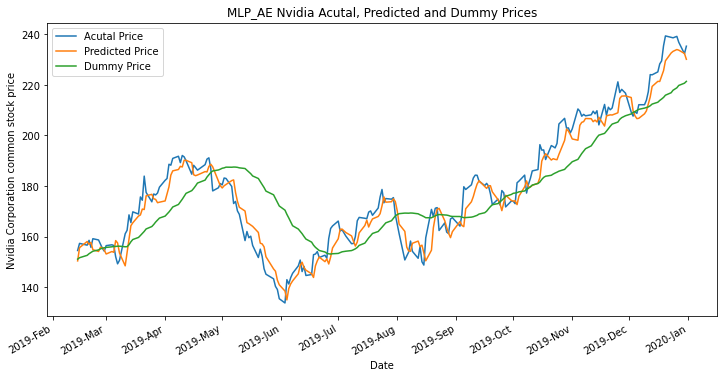

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

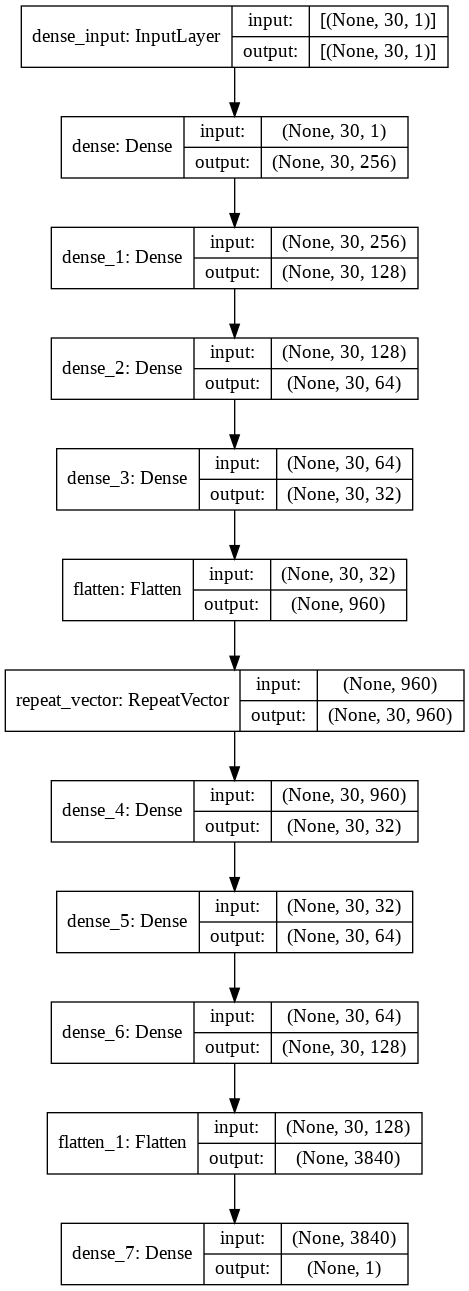

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0027683331155588563
RMSE:  0.05261495144499191
MAE:  0.04116167519140989
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_Nvidia/assets
